In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import zipfile
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
for dirname, _ ,  filenames in os.walk("./denoising-dirty-documents"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./denoising-dirty-documents\sampleSubmission.csv.zip
./denoising-dirty-documents\test.zip
./denoising-dirty-documents\train.zip
./denoising-dirty-documents\train_cleaned.zip


In [3]:
path_zip = './denoising-dirty-documents/'
path = './working/'

In [4]:
with zipfile.ZipFile(path_zip+'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
with zipfile.ZipFile(path_zip+'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
with zipfile.ZipFile(path_zip+'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
with zipfile.ZipFile(path_zip+'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

In [5]:
train_img = sorted(os.listdir(path+'train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [6]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (640, 480))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (480, 640, 1))
    return img

In [7]:
# def process_image(path):
#     img = cv2.imread(path)
#     img = np.asarray(img, dtype="float32")
#     img = cv2.resize(img, (540, 420))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = img/255.0
#     img = np.reshape(img, (420, 540, 1))
#     return img

In [8]:
train = []
train_cleaned = []
test = []


for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))

for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

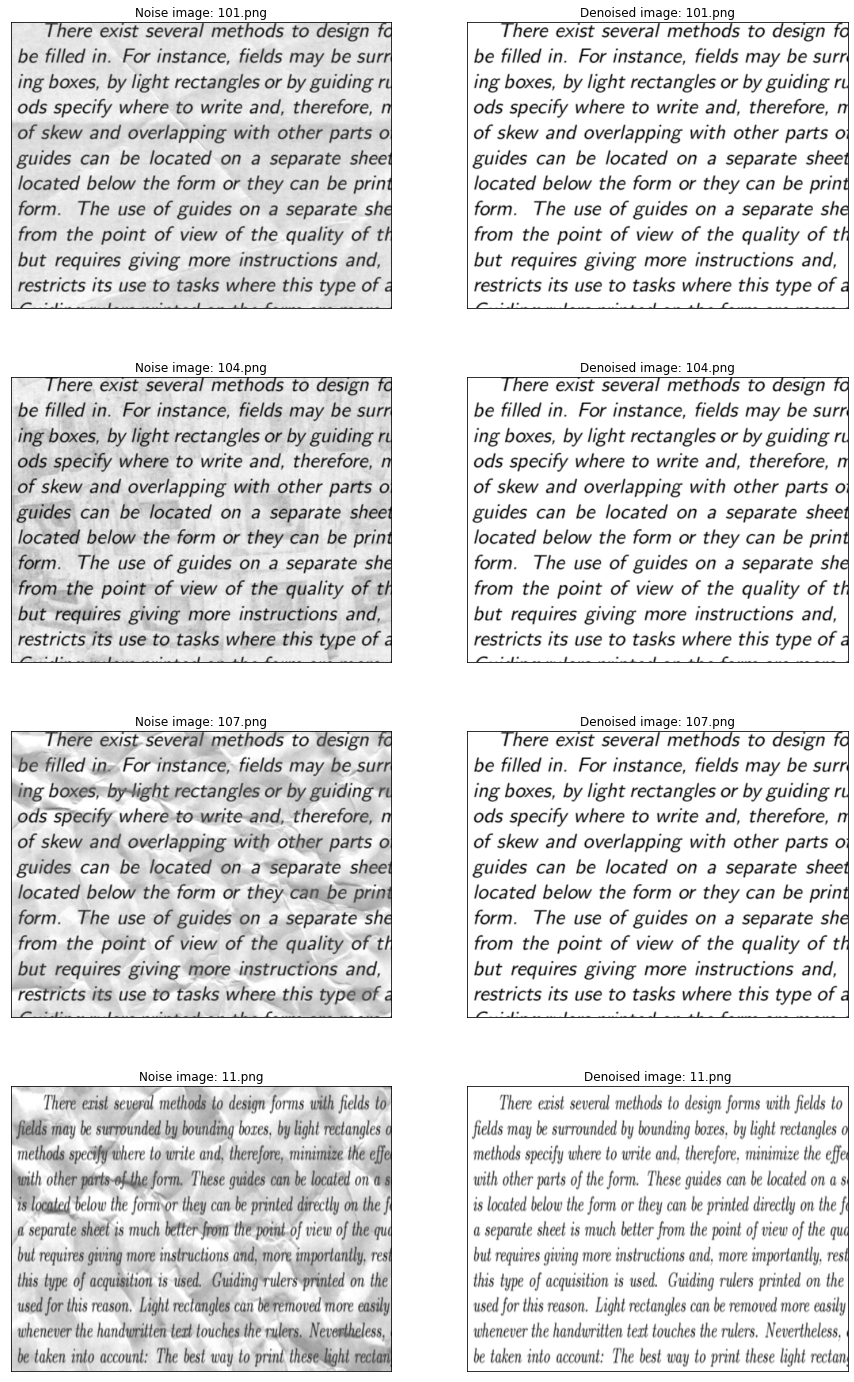

In [9]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [10]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [11]:
def model():
    input_layer = Input(shape=(480, 640, 1))
    x = Conv2D(64, (3,3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Dropout(0.5)(x)
    # decoding
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    
    output_layer = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model
model =model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 640, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 480, 640, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 480, 640, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 480, 640, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 240, 320, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 240, 320, 128)     0     

In [12]:
callback = EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=3, verbose=1, callbacks=[callback])

Epoch 1/100
41/41 [==============================] - 28s 451ms/step - loss: 0.0475 - mae: 0.1476 - val_loss: 0.0737 - val_mae: 0.2502
Epoch 2/100
41/41 [==============================] - 11s 275ms/step - loss: 0.0172 - mae: 0.0878 - val_loss: 0.0541 - val_mae: 0.1614
Epoch 3/100
41/41 [==============================] - 11s 275ms/step - loss: 0.0116 - mae: 0.0723 - val_loss: 0.0568 - val_mae: 0.1356
Epoch 4/100
41/41 [==============================] - 11s 273ms/step - loss: 0.0081 - mae: 0.0607 - val_loss: 0.0598 - val_mae: 0.1219
Epoch 5/100
41/41 [==============================] - 11s 274ms/step - loss: 0.0058 - mae: 0.0508 - val_loss: 0.0620 - val_mae: 0.1165
Epoch 6/100
41/41 [==============================] - 11s 275ms/step - loss: 0.0048 - mae: 0.0448 - val_loss: 0.0617 - val_mae: 0.1124
Epoch 7/100
41/41 [==============================] - 11s 276ms/step - loss: 0.0040 - mae: 0.0416 - val_loss: 0.0621 - val_mae: 0.1097
Epoch 8/100
41/41 [==============================] - 11s 277ms

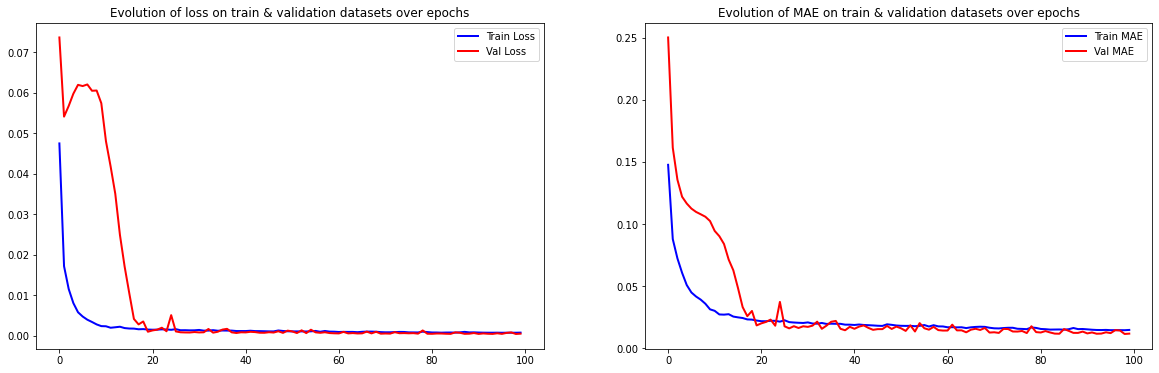

In [13]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')
plt.savefig("data1.png")

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')
plt.savefig("data2.png")

plt.show()

In [14]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=3)

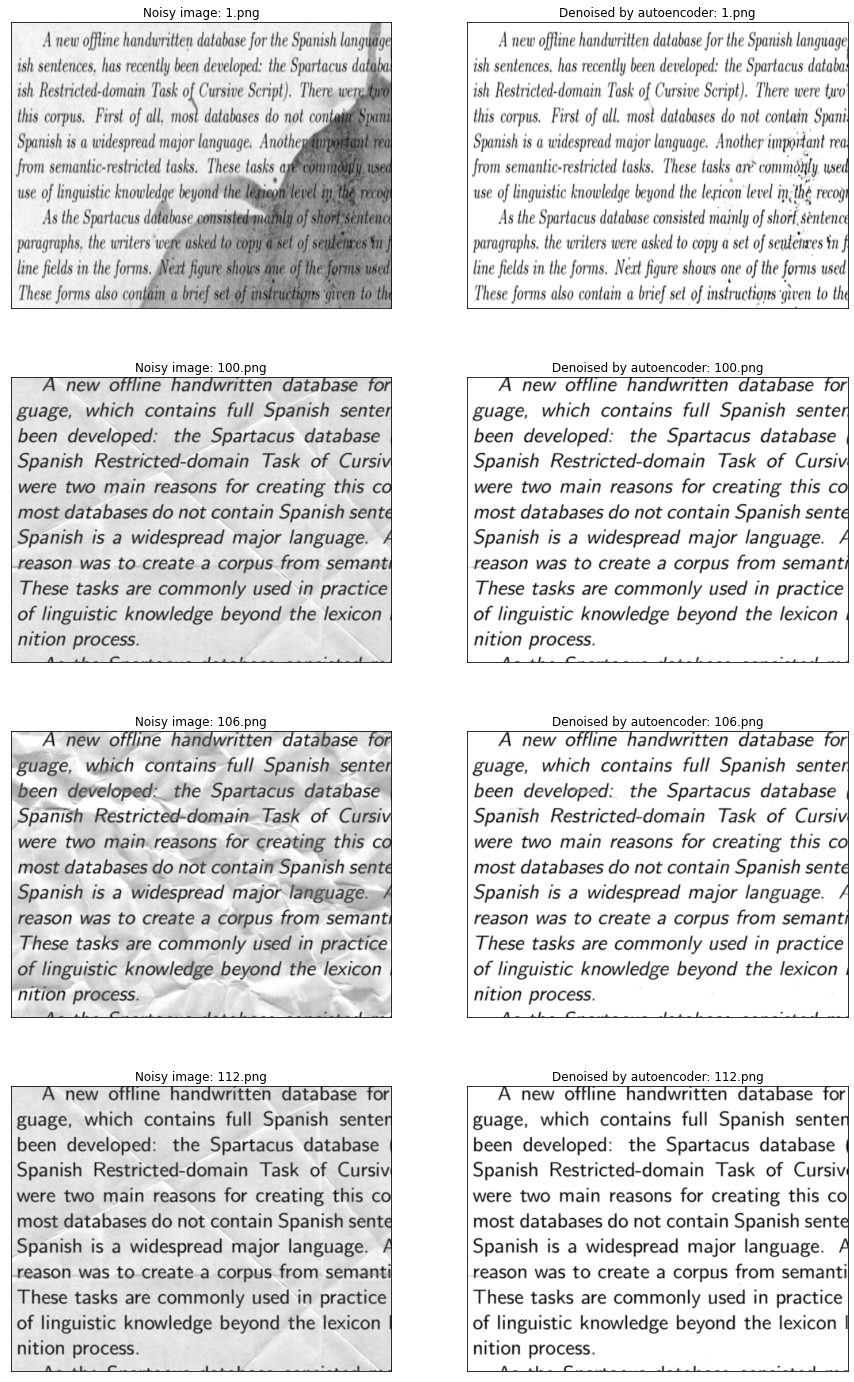

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [ ]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'